In [96]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

from tensorflow.keras.utils import image_dataset_from_directory, load_img, img_to_array 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AvgPool2D, Flatten, Dense, Dropout, RandomFlip, RandomRotation, RandomZoom, Rescaling, Input, Lambda
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.wrappers import SKLearnRegressor
from tensorboard.backend.event_processing import event_accumulator
from collections import Counter


# Data

In [97]:
# pass thru tf to convert paths to images
def preprocess_image(file_path, label):
    # final_path_file = data_dir+"/"+file_path
    img = tf.io.read_file(file_path)
    # rgb, later we normalize
    img = tf.image.decode_image(img, channels=3)
    # todo: make it optional passing to grayscale
    if grayscale:
        img = tf.image.rgb_to_grayscale(img)
        img.set_shape([None, None, 1])
    else:
        img.set_shape([None, None, 3]) #rgb
    img = tf.image.resize(img, image_size)
    return img, tf.one_hot(label, depth=len(class_names))

In [99]:
data_dir = "../data"
original_size = (300,200)
image_size = (37, 25)
batch_size = 32

file_paths = []
labels = []
class_names = os.listdir(data_dir)
class_to_index = {name: i for i, name in enumerate(class_names)}

for class_name in class_names:
    class_dir = f"{data_dir}/{class_name}"
    images = sorted(os.listdir(class_dir))
    for img_path in images:
        file_paths.append(class_dir + "/" + str(img_path))
        labels.append(class_to_index[class_name])

file_paths = np.array(file_paths)
labels = np.array(labels)
grayscale = False

X_train, X_val, y_train, y_val = train_test_split(
    file_paths,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

# for CV
cv_train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
cv_train_set = cv_train_set.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
cv_train_set = cv_train_set.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

cv_test_set = tf.data.Dataset.from_tensor_slices((X_val, y_val))
cv_test_set = cv_test_set.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
cv_test_set = cv_test_set.batch(batch_size).prefetch(tf.data.AUTOTUNE)


X_val, X_test, y_val, y_test = train_test_split(
    X_val,
    y_val,
    test_size=0.5,
    stratify=y_val,
    random_state=42
)

# for iteration over models
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_set = train_set.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_set = train_set.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_set = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_set = val_set.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_set = val_set.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_set = test_set.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_set = test_set.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [4]:
def count_label_distribution(dset):
    label_array = [x[1] for x in dset]
    
    labels_in_dset = []
    for x in label_array:
        labels_in_dset.extend(np.argmax(x, axis = 1))
    
    return len(labels_in_dset), Counter(labels_in_dset)
    

In [6]:
total_train, train_label_count = count_label_distribution(train_set)
total_val, val_label_count = count_label_distribution(val_set)
total_test, test_label_count = count_label_distribution(test_set)

total_cv_train, cv_train_label_count = count_label_distribution(cv_train_set)
total_cv_test, cv_test_label_count = count_label_distribution(cv_test_set)


In [7]:
train_label_count,val_label_count, test_label_count,cv_train_label_count,cv_test_label_count

(Counter({np.int64(2): 600, np.int64(1): 581, np.int64(0): 569}),
 Counter({np.int64(2): 75, np.int64(1): 73, np.int64(0): 71}),
 Counter({np.int64(2): 75, np.int64(0): 72, np.int64(1): 72}),
 Counter({np.int64(2): 600, np.int64(1): 581, np.int64(0): 569}),
 Counter({np.int64(2): 150, np.int64(1): 145, np.int64(0): 143}))

In [8]:
sum([total_train, total_val, total_test])

2188

In [9]:
len(file_paths)

2188

# Model

## Data Augmentation

In [10]:
# vertical here should only make sense since images are right-oriented
data_augmentation = Sequential([
    RandomFlip("vertical"),
    RandomRotation(0.05),
    RandomZoom(0.05)
])

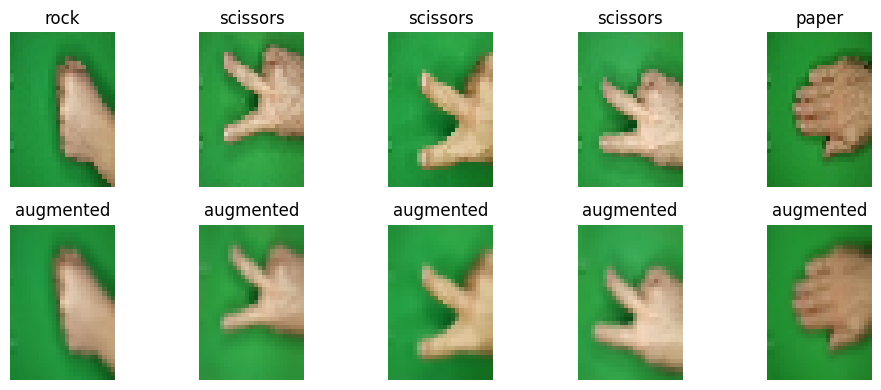

In [11]:
for images, label in train_set.take(1):
    augmented_images = data_augmentation(images)

    num_images = 5
    plt.figure(figsize=(10, 4))

    for i in range(num_images):
        # original
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(label[i])])
        plt.axis("off")

        # aug
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.title("augmented")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

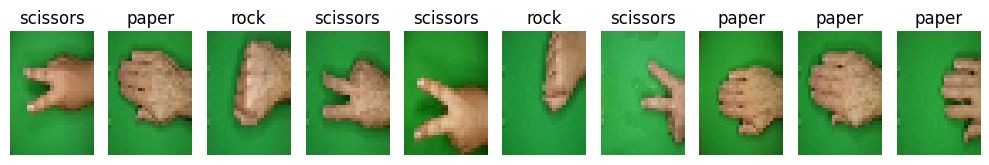

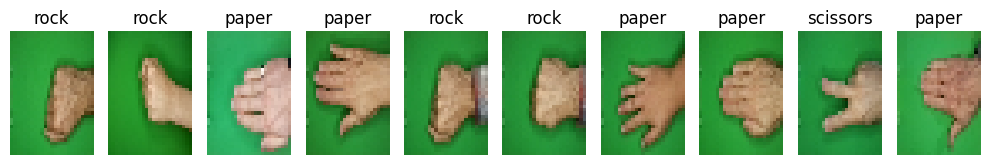

In [12]:
for images, label in val_set.take(2):
    # augmented_images = data_augmentation(images)
    num_images = 10
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(label[i])])
        plt.axis("off")
        

    plt.tight_layout()
    plt.show()

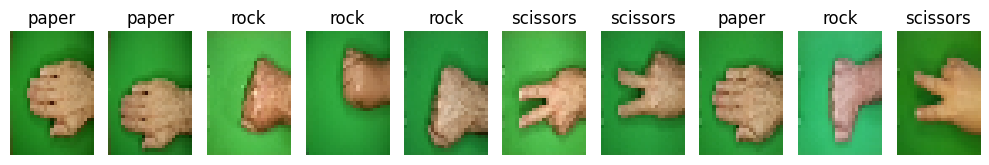

In [13]:
for images, label in test_set.take(1):
    # augmented_images = data_augmentation(images)
    num_images = 10
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(label[i])])
        plt.axis("off")
        

    plt.tight_layout()
    plt.show()

In [14]:
def show_misclassified_images(model, dataset, class_names, n=9):
    import numpy as np

    images = []
    true_labels = []
    pred_labels = []

    for img_batch, label_batch in dataset.unbatch().batch(1).take(1000):
        preds = model.predict(img_batch, verbose=0)
        pred_class = tf.argmax(preds[0])
        true_class = tf.argmax(label_batch[0])

        if pred_class != true_class:
            images.append(img_batch[0].numpy())
            true_labels.append(class_names[true_class.numpy()])
            pred_labels.append(class_names[pred_class.numpy()])

        if len(images) >= n:
            break

    plt.figure(figsize=(15, 10))
    for i in range(len(images)):
        plt.subplot(3, 3, i+1)

        img = images[i]
        if img.max() <= 1.0:
            img = img * 255.0
        img = np.clip(img.astype("uint8"), 0, 255)

        plt.imshow(img)
        plt.title(f"true: {true_labels[i]}\npred: {pred_labels[i]}", color='red')
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [15]:
def show_filters(model, layer_number = 2):
    filters, biases = model.layers[2].get_weights()

    # normalize
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)

    n_filters = filters.shape[3]
    grid_size = 32
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(20, 20))

    for i in range(grid_size * grid_size):
        ax = axs[i // grid_size, i % grid_size]
        ax.axis('off')
        
        if i < n_filters:
            f = filters[:, :, :, i]
            if f.shape[2] == 3:  # if rgb
                ax.imshow(f)
            else:  # grayscale
                ax.imshow(f[:, :, 0], cmap='gray')
        else:
            ax.set_visible(False)

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()


## First

### Using repeated runs

In [16]:
which_model = "first_architecture"

def root_logdir(architecture_name):
    return os.path.join(os.curdir, "logs\\"+architecture_name)

def get_run_logdir(architecture_name, it):
    import time
    run_id = str(it) +"_"+ time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return run_id, os.path.join(root_logdir(architecture_name), run_id)

def table_from_history(history_table, run_id):
    dft = pd.DataFrame(history_table)
    dft['run'] = run_id
    dft = dft.reset_index(names = "epoch")
    return dft 

In [17]:
def pass_imgs_labels(model, dset):
    
    imgs = []
    y_true = []
    y_pred = []

    for images, labels in dset:
        preds = model.predict(images) 
        y_pred.extend(np.argmax(preds, axis=1))
        y_true.extend(np.argmax(labels.numpy(), axis = 1))
        imgs.extend(images.numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    return y_true, y_pred, imgs

In [18]:
def compute_classification_metrics(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    str_summary = classification_report(y_true, y_pred, target_names=class_names)
    print(str_summary)
    
    # todo: manually compute other metrics
    return cm

In [19]:
def plot_conf_matrix(cm):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("pred")
    plt.ylabel("true")
    plt.show()

In [ ]:
number_of_iterations = 5

test_results = []
history_tables = []
for i in range(number_of_iterations):
    normalization_layer = Rescaling(1./255)

    if grayscale:
        dimension = 1
    else:
        dimension = 3
    model = Sequential([
        Input(shape = (image_size[0], image_size[1], dimension)),
        normalization_layer,
        data_augmentation,
        Conv2D(64, 3, activation = "relu", padding = "same"),
        MaxPooling2D(2),
        Flatten(),
        Dense(64, activation="relu"),
        Dense(3, activation = "softmax")
    ])

    model.compile(loss = "categorical_crossentropy",
                optimizer = "sgd",
                metrics = ["accuracy"])
    
    run_id, run_logdir = get_run_logdir("first_architecture", i)
    test_writer = tf.summary.create_file_writer(run_logdir+"/test")
    best_test_writer = tf.summary.create_file_writer(run_logdir+"/best_test")

    tensorboard_cb = TensorBoard(run_logdir)
    # saves model with best val_loss
    best_model_checkpoint = ModelCheckpoint(run_logdir+ "/first_model.keras", save_best_only=True)
    
    history = model.fit(train_set, validation_data=val_set, epochs=30, callbacks=[best_model_checkpoint,tensorboard_cb])
    tot_epochs = history.epoch[-1]
    
    best_model = tf.keras.models.load_model(run_logdir + "/first_model.keras")
    
    test_loss, test_accuracy = model.evaluate(test_set)
    best_test_loss, best_test_accuracy = best_model.evaluate(test_set)

    with test_writer.as_default():
        tf.summary.scalar('epoch_loss', test_loss, step=tot_epochs)
        tf.summary.scalar('epoch_accuracy', test_accuracy, step=tot_epochs)
    print(test_loss, test_accuracy)
    
    with best_test_writer.as_default():
        tf.summary.scalar('epoch_loss', best_test_loss, step=tot_epochs)
        tf.summary.scalar('epoch_accuracy', best_test_accuracy, step=tot_epochs)
    print(best_test_loss, best_test_accuracy)
    
    history_table = table_from_history(history.history, run_id)
    history_tables.append(history_table)
    test_results.append([run_id,test_loss, best_test_loss, test_accuracy, best_test_accuracy])
    
df_history = pd.concat(history_tables)
df_test = pd.DataFrame(test_results, columns = ['run', "test_loss", "best_test_loss", "test_accuracy", "best_test_accuracy"])
best_train_val = df_history.groupby('run').apply(lambda x: x.loc[x["val_loss"].idxmin()], include_groups = False).reset_index()
best_results = pd.merge(best_train_val, df_test, "inner", "run")
    


Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3964 - loss: 1.0840 - val_accuracy: 0.3744 - val_loss: 1.0170
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5566 - loss: 1.0043 - val_accuracy: 0.7032 - val_loss: 0.8777
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7028 - loss: 0.8866 - val_accuracy: 0.7763 - val_loss: 0.7442
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7231 - loss: 0.7732 - val_accuracy: 0.8219 - val_loss: 0.6261
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7579 - loss: 0.6981 - val_accuracy: 0.8539 - val_loss: 0.5484
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7497 - loss: 0.6718 - val_accuracy: 0.8676 - val_loss: 0.4986
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7928 - loss: 0.6145 - val_accuracy: 0.8082 - val_loss: 0.5336
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8290 - loss: 0.5248 - val_accuracy: 0.7945 - val_loss

- todo: choose the best model among different runs

In [26]:
best_results

,run,epoch,accuracy,loss,val_accuracy,val_loss,test_loss,best_test_loss,test_accuracy,best_test_accuracy,best_val_loss,best_val_accuracy
0,0_run_2025_07_14-14_03_36,28.0,0.934286,0.198547,0.958904,0.133188,0.232248,0.204986,0.926941,0.940639,0.133188,0.958904
1,1_run_2025_07_14-14_03_57,27.0,0.932000,0.201158,0.963470,0.140889,0.250704,0.222630,0.913242,0.931507,0.140889,0.963470
2,2_run_2025_07_14-14_04_19,28.0,0.935429,0.207865,0.945205,0.162329,0.237616,0.215783,0.917808,0.936073,0.162329,0.945205
3,3_run_2025_07_14-14_04_41,29.0,0.924571,0.241368,0.949772,0.177441,0.244356,0.244356,0.926941,0.926941,0.177441,0.949772
4,4_run_2025_07_14-14_05_03,26.0,0.930286,0.225983,0.949772,0.148842,0.245203,0.219585,0.913242,0.926941,0.148842,0.949772


In [97]:
y_true, y_pred, imgs  = pass_imgs_labels(best_model, test_set)
cm = compute_classification_metrics(y_true, y_pred, class_names=class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
              precision    recall  f1-score   support

       paper       1.00      0.85      0.92        72
        rock       0.95      0.97      0.96        72
    scissors       0.88      0.99      0.93        75

    accuracy                           0.94       219
   macro avg       0.94      0.94      0.94       219
weighted avg       0.94      0.94      0.94       219



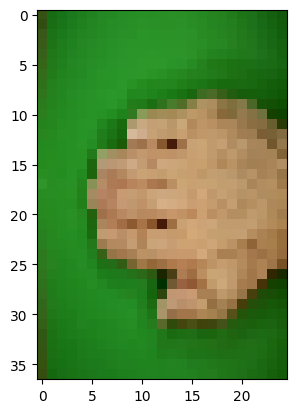

In [109]:
plt.imshow(imgs[0].astype(np.uint8))

In [123]:
pred_df = pd.DataFrame(zip(y_true, y_pred), columns = ['true', 'pred'])

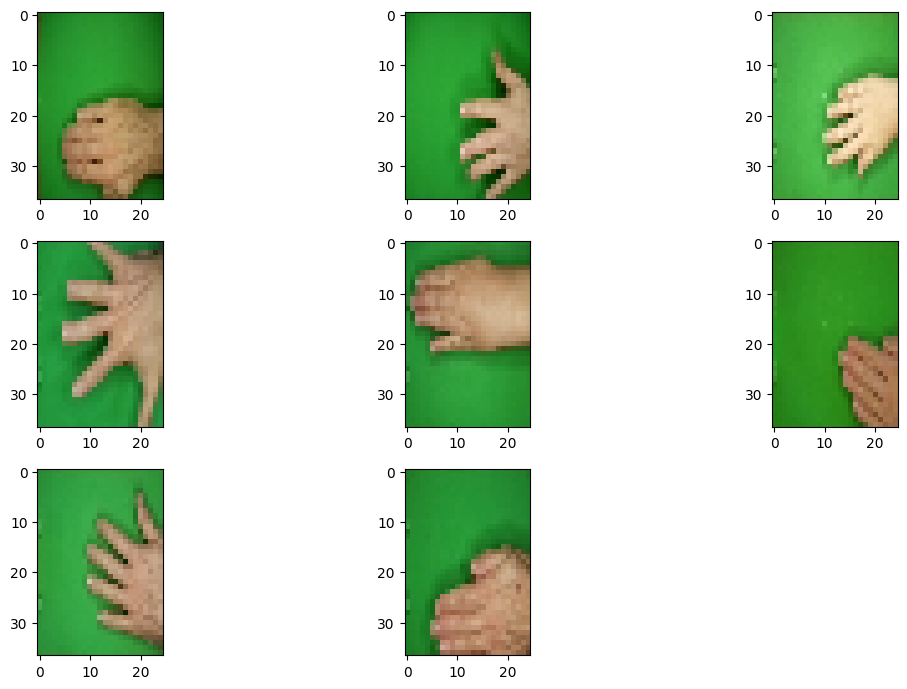

In [ ]:
wrong_preds = pred_df[(pred_df['true'] == 0) & (pred_df['pred'] == 2)].index

plt.figure(figsize = (12,7))

for i, idx in enumerate(wrong_preds):
    plt.subplot(3, 3, i+1)
    
    img = imgs[idx].astype(np.uint8)
    plt.imshow(img)
    # ax.title("asjda")
    
plt.tight_layout()
plt.show()



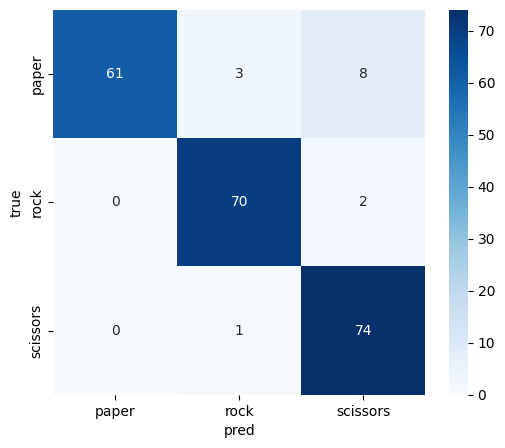

In [95]:
plot_conf_matrix(cm)

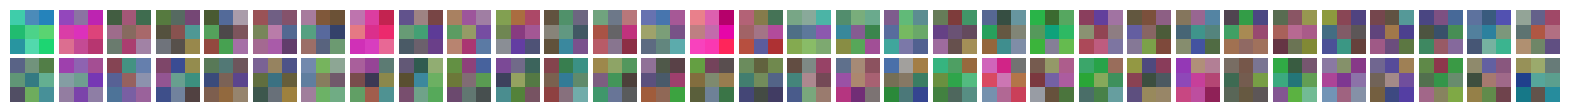

In [42]:
show_filters(model, 2)

### Using CV

- CV would give us slightly better results and also we can use it for hyperparameter tuning

In [ ]:
model = Sequential([
    Input(shape = (image_size[0], image_size[1], dimension)),
    normalization_layer,
    data_augmentation,
    Conv2D(64, 3, activation = "relu", padding = "same"),
    MaxPooling2D(2),
    Flatten(),
    Dense(64, activation="relu"),
    Dense(3, activation = "softmax")
])

model.compile(loss = "categorical_crossentropy",
        optimizer = "sgd",
        metrics = ["accuracy"])

run_id, run_logdir = get_run_logdir("first_architecture", i)
test_writer = tf.summary.create_file_writer(run_logdir+"/test")
best_test_writer = tf.summary.create_file_writer(run_logdir+"/best_test")

tensorboard_cb = TensorBoard(run_logdir)
# saves model with best val_loss
best_model_checkpoint = ModelCheckpoint(run_logdir+ "/first_model.keras", save_best_only=True)

history = model.fit(train_set, validation_data=val_set, epochs=30, callbacks=[best_model_checkpoint,tensorboard_cb])

In [76]:
normalization_layer = Rescaling(1./255)
data_augmentation = Sequential([
    RandomFlip("vertical"),
    RandomRotation(0.05),
    RandomZoom(0.05)
])

if grayscale:
    dimension = 1
else:
    dimension = 3

def build_first_model(n_filters = 64, n_neurons = 64, learning_rate = 1e-2, momentum = 0.0, 
                      kernel_size = 3, pool_size = 2):
    
    model = Sequential([
    Input(shape = (image_size[0], image_size[1], dimension)),
    normalization_layer,
    data_augmentation,
    Conv2D(n_filters, kernel_size, activation = "relu", padding = "same"),
    MaxPooling2D(pool_size),
    Flatten(),
    Dense(n_neurons, activation="relu"),
    Dense(3, activation = "softmax")
                    ])
    
    optimizer = SGD(learning_rate=learning_rate, momentum=momentum)
    
    model.compile(loss = "sparse_categorical_crossentropy",
        optimizer = optimizer,
        metrics = ["accuracy"])
    
    return model

In [77]:
def pass_batchs_to_arrays(dset, pass_dummy = False):

    X_list = []
    y_list = []

    for x_batch, y_batch in dset:
        X_list.append(x_batch.numpy())
        y_list.append(y_batch.numpy())

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    
    if pass_dummy:
        y = np.argmax(y, axis = 1)
    
    return X, y


In [83]:
X_train_array, y_train_array = pass_batchs_to_arrays(cv_train_set)
y_train_array = np.argmax(y_train_array, axis = 1)

X_test_array, y_test_array = pass_batchs_to_arrays(cv_test_set)
y_test_array = np.argmax(y_test_array, axis = 1)

In [85]:
skf = StratifiedKFold(n_splits=2, shuffle = True, random_state=42)

In [ ]:
history_tables = []

for i, (train_i, val_i) in enumerate(skf.split(X_train_array, y_train_array)):
    fold = f"Fold {i+1}"
    
    # data
    X_train, y_train = X_train_array[train_i], y_train_array[train_i]
    X_val, y_val = X_train_array[val_i], y_train_array[val_i]
    
    model = build_first_model()
    
    #todo: define callbacks here before fit
    history = model.fit(X_train, y_train, validation_data=(X_val,y_val), 
                        epochs=30)
    
    history_tables.append(table_from_history(history.history, fold))    
    
    

Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3638 - loss: 1.0944 - val_accuracy: 0.5097 - val_loss: 1.0737
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4845 - loss: 1.0684 - val_accuracy: 0.3863 - val_loss: 1.0541
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4835 - loss: 1.0382 - val_accuracy: 0.5269 - val_loss: 1.0161
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5977 - loss: 0.9989 - val_accuracy: 0.4811 - val_loss: 0.9747
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6128 - loss: 0.9577 - val_accuracy: 0.4926 - val_loss: 0.9344
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6998 - loss: 0.9012 - val_accuracy: 0.5909 - val_loss: 0.9142
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6870 - loss: 0.8675 - val_accuracy: 0.6651 - val_loss: 0.8307
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7086 - loss: 0.8073 - val_accuracy: 0.4640 - va

In [92]:
df_history = pd.concat(history_tables)
best_train_val = df_history.groupby('run').apply(lambda x: x.loc[x["val_loss"].idxmin()], include_groups = False).reset_index()

In [93]:
best_train_val

,run,epoch,accuracy,loss,val_accuracy,val_loss
0,Fold 1,29.0,0.878857,0.369207,0.889143,0.322382
1,Fold 2,28.0,0.864000,0.373990,0.883429,0.341391


## Second

## Third